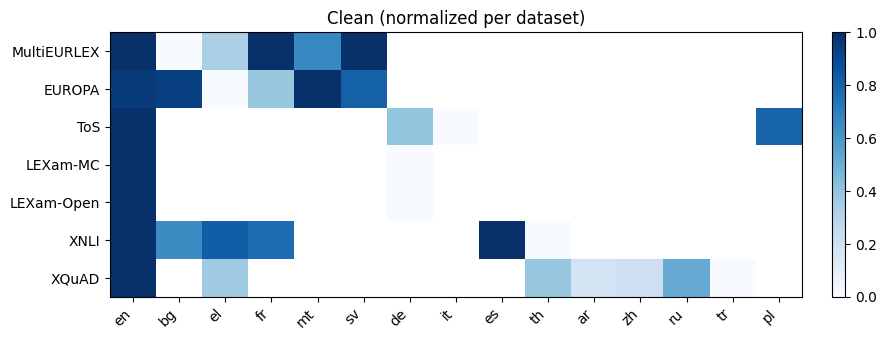

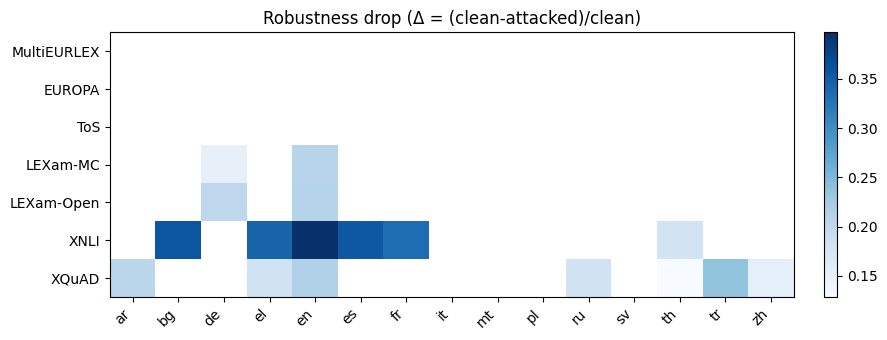

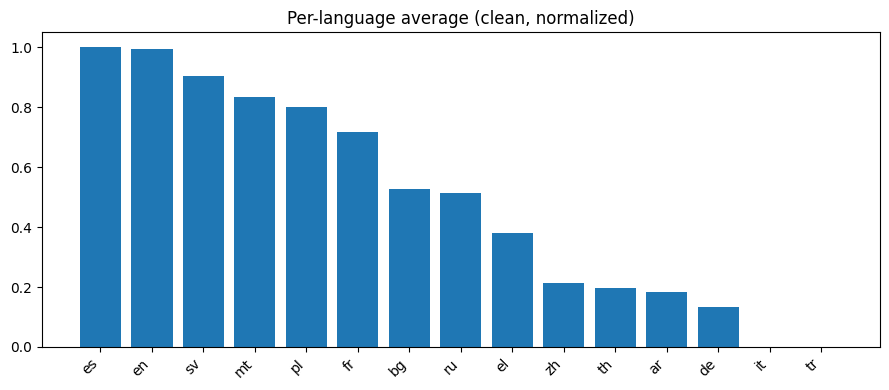

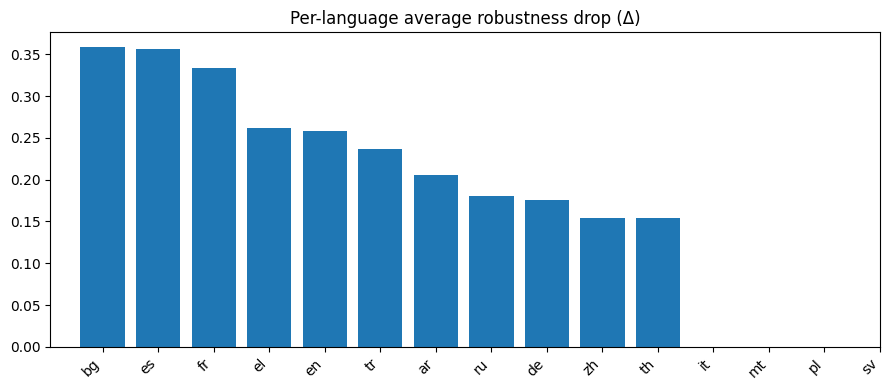

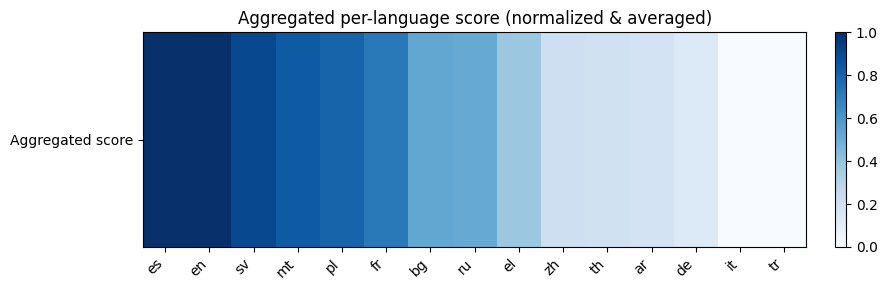

Saved: ./aggregated/overview_gemini_1.5_minmax_20250906_175424.json


In [43]:
from __future__ import annotations
from typing import Dict, Any, Optional, Iterable, Literal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, datetime, os
import pandas as pd
import numpy as np
from typing import Dict, Any

NormMethod = Literal["minmax", "best", "zscore"]
AttackReduce = Literal["mean", "min", "max"]

# -------------------------------
# Normalization utilities
# -------------------------------

def _normalize_series(s: pd.Series, method: NormMethod, z_clip: float = 2.0) -> pd.Series:
    """Row-wise normalization of a 1D Series (one dataset across languages)."""
    s = s.copy()
    if method == "minmax":
        vmin = s.min(skipna=True); vmax = s.max(skipna=True)
        if pd.isna(vmin) or pd.isna(vmax) or vmax == vmin:
            return s.apply(lambda x: np.nan if pd.isna(x) else 0.5)
        return (s - vmin) / (vmax - vmin)

    if method == "best":
        vmax = s.max(skipna=True)
        if pd.isna(vmax) or vmax == 0:
            return s.apply(lambda x: np.nan if pd.isna(x) else 0.5)
        return s / vmax  # best=1.0; others keep relative closeness

    if method == "zscore":
        mu = s.mean(skipna=True); sd = s.std(skipna=True)
        if pd.isna(mu) or pd.isna(sd) or sd == 0:
            # All equal or degenerate → neutral 0.5
            z = s.apply(lambda x: np.nan if pd.isna(x) else 0.0)
        else:
            z = (s - mu) / sd
        # clip to [-z_clip, z_clip] then map to [0,1]
        z = z.clip(-z_clip, z_clip)
        return (z + z_clip) / (2 * z_clip)

    raise ValueError(f"Unknown normalization method: {method}")

def _normalize_df(df: pd.DataFrame, method: NormMethod = "best", z_clip: float = 2.0) -> pd.DataFrame:
    """Apply chosen normalization row-wise (per dataset)."""
    return df.apply(lambda row: _normalize_series(row, method=method, z_clip=z_clip), axis=1)

# -------------------------------
# Parsing attacked structures
# -------------------------------

def _extract_attacked_map(attacked_obj: Any,
                          attack: Optional[str],
                          reduce: AttackReduce = "mean") -> Dict[str, float]:
    if not isinstance(attacked_obj, dict) or not attacked_obj:
        return {}
    sample_val = next(iter(attacked_obj.values()))
    is_nested = isinstance(sample_val, dict)
    if not is_nested:
        return {l: float(v) for l, v in attacked_obj.items() if v is not None}
    if attack is not None and attack in attacked_obj:
        return {l: float(v) for l, v in attacked_obj[attack].items() if v is not None}
    per_lang: Dict[str, list] = {}
    for _, lang_map in attacked_obj.items():
        if not isinstance(lang_map, dict):
            continue
        for l, v in lang_map.items():
            if v is None: continue
            per_lang.setdefault(l, []).append(float(v))
    agg = {}
    for l, vals in per_lang.items():
        if not vals: continue
        if reduce == "mean": agg[l] = float(np.mean(vals))
        elif reduce == "min": agg[l] = float(np.min(vals))
        elif reduce == "max": agg[l] = float(np.max(vals))
        else: agg[l] = float(np.mean(vals))
    return agg

# -------------------------------
# Core builders (per model / all)
# -------------------------------

def build_overview_for_model(
        results: Dict[str, Dict[str, Any]],
        model_name: str,
        language_order: Optional[Iterable[str]] = None,
        dataset_order: Optional[Iterable[str]] = None,
        attack: Optional[str] = None,
        attack_reduce: AttackReduce = "mean",
        normalize: NormMethod = "best",     # <<< choose: "best" | "minmax" | "zscore"
        z_clip: float = 2.0,                # used only for zscore mapping
) -> Dict[str, Any]:
    datasets_all = [d for d, payload in results.items() if "model" in payload and model_name in payload["model"]]
    datasets = [d for d in (dataset_order or datasets_all) if d in datasets_all]

    langs = set()
    for d in datasets:
        entry = results[d]["model"][model_name]
        clean_map = entry.get("clean", {}) or {}
        attacked_map = _extract_attacked_map(entry.get("attacked", {}) or {}, attack, attack_reduce)
        langs.update(clean_map.keys()); langs.update(attacked_map.keys())

    languages = [l for l in (language_order or sorted(langs)) if l in langs]

    clean_df   = pd.DataFrame(index=datasets, columns=languages, dtype=float)
    attacked_df= pd.DataFrame(index=datasets, columns=languages, dtype=float)

    for d in datasets:
        entry = results[d]["model"][model_name]
        clean_map = entry.get("clean", {}) or {}
        attacked_map = _extract_attacked_map(entry.get("attacked", {}) or {}, attack, attack_reduce)
        for l, v in clean_map.items():   clean_df.loc[d, l] = v
        for l, v in attacked_map.items():attacked_df.loc[d, l] = v

    clean_norm    = _normalize_df(clean_df,    method=normalize, z_clip=z_clip)
    attacked_norm = _normalize_df(attacked_df, method=normalize, z_clip=z_clip)

    delta = (clean_df - attacked_df) / clean_df
    delta = delta.replace([np.inf, -np.inf], np.nan)

    lang_agg_clean = clean_norm.mean(axis=0, skipna=True)
    coverage_clean = clean_norm.count(axis=0)

    lang_agg_delta = delta.mean(axis=0, skipna=True)
    coverage_delta = delta.count(axis=0)

    return {
        "clean_df_raw": clean_df,
        "attacked_df_raw": attacked_df,
        "clean_df_norm": clean_norm,
        "attacked_df_norm": attacked_norm,
        "delta_df": delta,
        "lang_agg_clean": lang_agg_clean,
        "lang_agg_delta": lang_agg_delta,
        "coverage_clean": coverage_clean,
        "coverage_delta": coverage_delta,
    }

def build_overview_all_models(
        results: Dict[str, Dict[str, Any]],
        models: Optional[Iterable[str]] = None,
        **kwargs
) -> Dict[str, Dict[str, Any]]:
    all_models = set()
    for _, payload in results.items():
        all_models.update(payload.get("model", {}).keys())
    target_models = list(models) if models is not None else sorted(all_models)
    return {m: build_overview_for_model(results, model_name=m, **kwargs) for m in target_models}

# -------------------------------
# (Optional) plotting helpers
# -------------------------------

def plot_heatmap(df: pd.DataFrame, title: str, cmap: Optional[str] = None):
    plt.figure(figsize=(max(6, 0.6*df.shape[1]), max(3, 0.5*df.shape[0])))
    im = plt.imshow(df.values, aspect='auto', interpolation='nearest', cmap='Blues')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.yticks(range(df.shape[0]), df.index)
    plt.xticks(range(df.shape[1]), df.columns, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_language_bar(lang_series: pd.Series, title: str):
    s = lang_series.sort_values(ascending=False)
    plt.figure(figsize=(max(6, 0.6*len(s)), 4))
    plt.bar(range(len(s)), s.values)
    plt.xticks(range(len(s)), s.index, rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def _df_to_split(df: pd.DataFrame) -> Dict[str, Any]:
    return {"__type__":"dataframe","payload": df.to_dict(orient="split")}

def _split_to_df(obj: Dict[str, Any]) -> pd.DataFrame:
    return pd.DataFrame(**obj["payload"])

def _series_to_split(s: pd.Series) -> Dict[str, Any]:
    # preserve dtype where possible
    return {"__type__":"series","payload": {"index": list(s.index), "values": list(map(lambda x: None if pd.isna(x) else float(x), s.values))}}

def _split_to_series(obj: Dict[str, Any]) -> pd.Series:
    idx = obj["payload"]["index"]
    vals = obj["payload"]["values"]
    return pd.Series(vals, index=idx, dtype=float)

def _is_df(obj):     return isinstance(obj, dict) and obj.get("__type__")=="dataframe"
def _is_series(obj): return isinstance(obj, dict) and obj.get("__type__")=="series"


def save_overview_bundle(
        out: Dict[str, Any],
        params: Dict[str, Any],
        path: str,
        extra_meta: Dict[str, Any] | None = None
):
    """
    out: the dict you currently return from build_overview_for_model(...)
    params: the exact knobs you used (model_name, dataset_order, language_order, attack, normalize, z_clip, etc.)
    path: where to write (e.g., './artifacts/overview_bundle.json')
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    bundle = {
        "meta": {
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            **(extra_meta or {})
        },
        "params": params,
        "data": {
            "clean_df_raw":       _df_to_split(out["clean_df_raw"]),
            "attacked_df_raw":    _df_to_split(out["attacked_df_raw"]),
            "clean_df_norm":      _df_to_split(out["clean_df_norm"]),
            "attacked_df_norm":   _df_to_split(out["attacked_df_norm"]),
            "delta_df":           _df_to_split(out["delta_df"]),
            "lang_agg_clean":     _series_to_split(out["lang_agg_clean"]),
            "lang_agg_delta":     _series_to_split(out["lang_agg_delta"]),
            "coverage_clean":     _series_to_split(out["coverage_clean"]),
            "coverage_delta":     _series_to_split(out["coverage_delta"]),
        }
    }

    with open(path, "w", encoding="utf-8") as f:
        json.dump(bundle, f, ensure_ascii=False)

def load_overview_bundle(path: str) -> Dict[str, Any]:
    with open(path, "r", encoding="utf-8") as f:
        bundle = json.load(f)

    data = bundle["data"]
    restored = {
        "clean_df_raw":     _split_to_df(data["clean_df_raw"]),
        "attacked_df_raw":  _split_to_df(data["attacked_df_raw"]),
        "clean_df_norm":    _split_to_df(data["clean_df_norm"]),
        "attacked_df_norm": _split_to_df(data["attacked_df_norm"]),
        "delta_df":         _split_to_df(data["delta_df"]),
        "lang_agg_clean":   _split_to_series(data["lang_agg_clean"]),
        "lang_agg_delta":   _split_to_series(data["lang_agg_delta"]),
        "coverage_clean":   _split_to_series(data["coverage_clean"]),
        "coverage_delta":   _split_to_series(data["coverage_delta"]),
        "params":           bundle.get("params", {}),
        "meta":             bundle.get("meta", {}),
    }
    return restored
    

if __name__ == "__main__":
    results = {
        "MultiEURLEX": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 0.21, "bg": 0.18, "el": 0.19, "fr": 0.21, "mt": 0.20, "sv": 0.21},
                            "attacked": {},
                           }
                     },
            "legal": True,
        },
        "Eur-Lex-Sum": {
            "model": { "llama":
                        {
                    "clean":    {},
                    "attacked": {},
                        }
                    },
            "legal": True,
        },
        "EUROPA": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 3.77, "el": 3.32, "bg": 3.76, "mt": 3.79, "fr": 3.50, "sv": 3.70},
                            "attacked": {},
                            }
                       },
            "legal": True,
        },
        "ToS": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 0.66, "de": 0.63, "it": 0.61, "pl": 0.65},
                            "attacked": {},
                            }
                       },
            "legal": True,
        },
        "LEXam-MC": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 0.48, "de": 0.40},
                            "attacked": {"en": 0.38, "de": 0.34},
                            },
                       "gemini_2.5":
                           {"clean":    {"en": 0.74, "de": 0.51},
                            "attacked": {"char_attack": {"en": 0.74, "de": 0.47},
                                         "word_attack": {"en": 0.50, "de": 0.43},}
                            }
                       },
            "legal": True,
        },
        "LEXam-Open": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 3.71, "de": 2.77},
                            "attacked": {"en": 2.93, "de": 2.21},
                            },
                       "gemini_2.5":
                           {"clean":    {"en": 4.14, "de": 3.62},
                            "attacked": {"char_attack": {"en": 4.02, "de": 3.19},
                                        "word_attack": {"en": 3.28, "de": 2.47},}
                            }
                       },
            "legal": True,
        },
        "XNLI": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 0.73, "el": 0.70, "bg": 0.67, "es": 0.73, "fr": 0.69, "th": 0.56},
                            "attacked": {"en": 0.44, "el": 0.46, "bg": 0.43, "es": 0.47, "fr": 0.46, "th": 0.46},
                            },
                       "llama":
                           {"clean": {},
                            "attacked": {}},
                       },
            "legal": False,
        },
        "XQuAD": {
            "model": { "gemini_1.5":
                           {"clean":    {"en": 4.94, "el": 4.73, "ar": 4.67, "zh": 4.68, "ru": 4.78, "th": 4.74, "tr": 4.61},
                            "attacked": {"en": 3.88, "el": 3.88, "ar": 3.71, "zh": 3.96, "ru": 3.92, "th": 4.13, "tr": 3.52},
                            }
                       },
            "legal": False,
        },
    }

    params = {
        "model_name": "gemini_1.5",
        "language_order": ["en","bg","el","fr","mt","sv","de","it","es","th","ar","zh","ru","tr"],
        "dataset_order": ["MultiEURLEX","EUROPA","Eur-Lex-Sum","ToS","LEXam-MC","LEXam-Open","XNLI","XQuAD"],
        "attack": None,          # or "char_attack" / "word_attack"
        "attack_reduce": "mean", # used if attack=None and multiple attacks exist
        "normalize": "minmax",   # or "best" / "zscore"
        "z_clip": 2.0,           # only used when normalize == "zscore"
    }
    
    out = build_overview_for_model(results, **params)

    # Access outputs
    clean_norm   = out["clean_df_norm"]
    delta_drop   = out["delta_df"]
    lang_avg     = out["lang_agg_clean"]
    lang_avg_dlt = out["lang_agg_delta"]

    lang_avg_clean = lang_avg.dropna().sort_values(ascending=False)    
    # Make a 1×N matrix for the heatmap
    agg_mat = lang_avg_clean.to_frame().T
    agg_mat.index = ["Aggregated score"]  # single row label

    # Plots (optional)
    plot_heatmap(clean_norm,  "Clean (normalized per dataset)")
    plot_heatmap(delta_drop,  "Robustness drop (Δ = (clean-attacked)/clean)")
    plot_language_bar(lang_avg,     "Per-language average (clean, normalized)")
    plot_language_bar(lang_avg_dlt, "Per-language average robustness drop (Δ)")
    plot_heatmap(agg_mat, "Aggregated per-language score (normalized & averaged)")

    ts = datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    out_path = f"./aggregated/overview_{params['model_name']}_{params['normalize']}_{ts}.json"
    save_overview_bundle(out, params, out_path, extra_meta={})
    print(f"Saved: {out_path}")



## Creates Plot for Similarity to English vs Aggregated Score

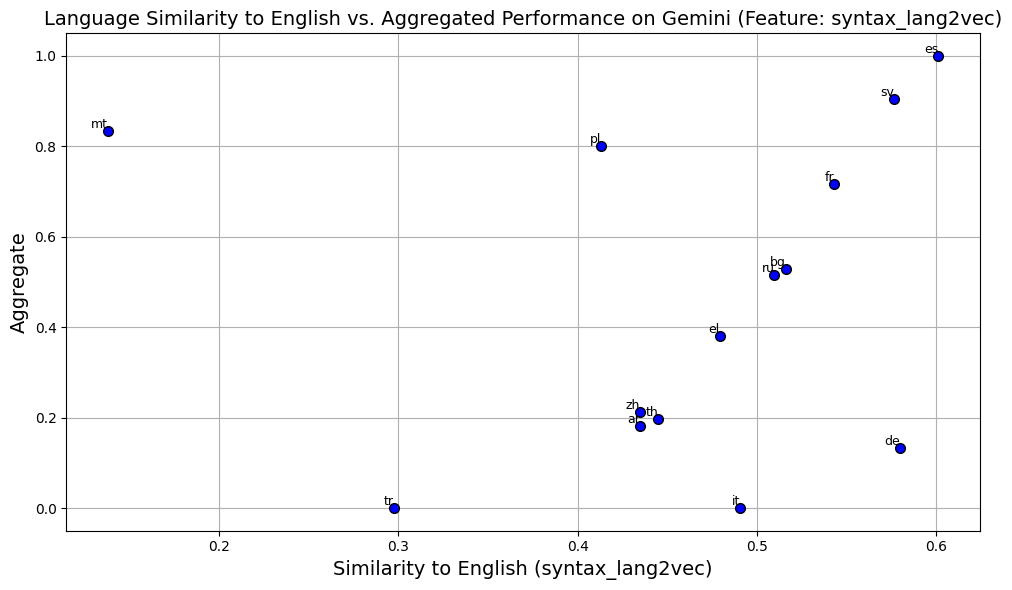

Saved: ./aggregated/overview\Aggregate_vs_similarity_syntax_lang2vec_20250906_190638.pdf


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

# ISO 639-1 → ISO 639-3
iso2_to_iso3 = {
    'en':'eng','bg':'bul','el':'ell','fr':'fra','mt':'mlt','sv':'swe',
    'de':'deu','it':'ita','es':'spa','th':'tha','ar':'ara','zh':'zho',
    'ru':'rus','tr':'tur','pl':'pol','ro':'ron','nl':'nld','cs':'ces',
    'da':'dan','fi':'fin','hu':'hun','pt':'por','sk':'slk','sl':'slv',
}

def load_similarity_to_english(feature_file: str, use_precomputed: bool = True) -> pd.DataFrame:
    """
    Returns a DataFrame with columns: iso3, similarity
    where similarity = 1 - distance(lang, eng) if using precomputed Lang2Vec matrices.
    """
    if use_precomputed:
        df_wide = pd.read_csv(feature_file)
        df_wide = df_wide.rename(columns={df_wide.columns[0]: 'lang1'})
        df_long = df_wide.melt(id_vars='lang1', var_name='lang2', value_name='distance')
        eng_df = df_long[(df_long['lang1'] == 'eng') & (df_long['lang2'] != 'eng')].copy()
        eng_df['similarity'] = 1.0 - eng_df['distance']
        eng_df['iso3'] = eng_df['lang2']
        return eng_df[['iso3','similarity']].dropna()
    else:
        df = pd.read_csv(feature_file)
        df = df.rename(columns={'language_1':'lang1','language_2':'lang2'})
        eng_df = df[
            ((df['lang1'] == 'eng') & (df['lang2'] != 'eng')) |
            ((df['lang2'] == 'eng') & (df['lang1'] != 'eng'))
            ].copy()
        eng_df['iso3'] = eng_df.apply(lambda r: r['lang2'] if r['lang1']=='eng' else r['lang1'], axis=1)
        return eng_df[['iso3','similarity']].dropna()


def plot_similarity_vs_aggregate(
        similarity_df: pd.DataFrame,
        aggregate_df: pd.DataFrame,
        feature_name: str,
        metric_name: str = "Aggregate",
        title_prefix: str = "Similarity vs. Aggregated Performance",
        out_dir: str = "./aggregated/overview"
):
    """
    Merges similarity and aggregate and makes a scatter with labels.
    """
    merged = similarity_df.merge(aggregate_df, on='iso3', how='inner')
    if merged.empty:
        print("No overlap between similarity languages and aggregate languages.")
        return

    os.makedirs(out_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    plt.figure(figsize=(10,6))
    plt.errorbar(
        merged['similarity'], merged[metric_name],
        fmt='o', markerfacecolor='blue', markeredgecolor='black', markersize=7
    )
    for _, row in merged.iterrows():
        plt.text(row['similarity'], row[metric_name], row['language'], fontsize=9, ha='right', va='bottom')

    plt.xlabel(f"Similarity to English ({feature_name})", fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(f"{title_prefix} (Feature: {feature_name})", fontsize=14)
    plt.grid(True)
    plt.tight_layout()

    out_path = os.path.join(out_dir, f"{metric_name}_vs_similarity_{feature_name}_{timestamp}.pdf")
    plt.savefig(out_path, format='pdf')
    plt.show()
    print(f"Saved: {out_path}")

languages_15 = ["en","bg","el","fr","mt","sv","de","it","es","th","ar","zh","ru","tr","pl"]

bundle_path = "./aggregated/overview_gemini_1.5_minmax_20250906_162121.json"
bundle = load_overview_bundle(bundle_path)

# Grab the aggregate series and format it like before
s = bundle["lang_agg_clean"]  # pandas Series indexed by iso2 codes
agg_df = s.rename("Aggregate").reset_index().rename(columns={'index':'language'})
agg_df = agg_df[agg_df['language'].isin(languages_15)]  # optional: filter to your 15
agg_df['iso3'] = agg_df['language'].map(iso2_to_iso3)
agg_df = agg_df[['language','iso3','Aggregate']].dropna()

# Similarity files
distance_root = "../../data/language_similarity/lang2vec/distances"
feature_files = {
    "syntax_lang2vec":     f"{distance_root}/SYNTACTIC.csv",
}

for feat, path in feature_files.items():
    if not os.path.exists(path):
        print(f"Missing: {path}")
        continue
    sim_df = load_similarity_to_english(path, use_precomputed=True)
    plot_similarity_vs_aggregate(
        similarity_df=sim_df,
        aggregate_df=agg_df,
        feature_name=feat,
        metric_name="Aggregate",
        title_prefix="Language Similarity to English vs. Aggregated Performance on Gemini"
    )
